In the first 2 code fragments we set up tensorflow version 2.x and we create sampling function and a plotting function. The idea of this code piece is to run a VAE which will have 2 latent features. These features will be plotted with the actual number colour coded on the plot.

In [6]:
#%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir("/content/drive/My Drive/dcu/future Learn_v2/MOOC 4 - CA683 - Feature engineering/M4 Colab Files/Data")
#!ls

2.1.0


In [7]:
x  =5+5

In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()



Now we will 

In [11]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.keras.layers import Lambda, Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.losses import mse, binary_crossentropy
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os





# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Now we reshape the image to a flattened NumPy array and build the VAE. We plot the encoder and the decoder. Note how the sampling function is called using Keras Lambda function. 

In [12]:

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()



# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()



# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

#parser = argparse.ArgumentParser()
#help_ = "Load h5 model trained weights"
#parser.add_argument("-w", "--weights", help=help_)
#help_ = "Use mse loss instead of binary cross entropy (default)"
#parser.add_argument("-m","--mse", help=help_, action='store_true')
#args = parser.parse_args()
models = (encoder, decoder)
data = (x_test, y_test)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

In [13]:

reconstruction_loss = mse(inputs, outputs)
#reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          403728      encoder[1][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
____________________________________________________________________________________________

The next thing we will do is fit the model. This is a very complicated model. I don't expect you to be able to understand the intricacies of it. Just try and grasp the fact the latent component is built on a probabilistic approach. 




In [14]:


#if args.weights:
#  vae.load_weights(args.weights)
#else:
    # train the autoencoder
    #epochs
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 191us/sample - loss: 52.4061 - val_loss: 43.8659
Epoch 2/50
60000/60000 [==============================] - 9s 155us/sample - loss: 43.3512 - val_loss: 42.5076
Epoch 3/50
60000/60000 [==============================] - 9s 148us/sample - loss: 42.3415 - val_loss: 41.8056
Epoch 4/50
60000/60000 [==============================] - 10s 162us/sample - loss: 41.7031 - val_loss: 41.2477
Epoch 5/50
60000/60000 [==============================] - 11s 186us/sample - loss: 41.2103 - val_loss: 40.8503
Epoch 6/50
60000/60000 [==============================] - 9s 154us/sample - loss: 40.8304 - val_loss: 40.4713
Epoch 7/50
60000/60000 [==============================] - 9s 152us/sample - loss: 40.5271 - val_loss: 40.3450
Epoch 8/50
60000/60000 [==============================] - 9s 158us/sample - loss: 40.2717 - val_loss: 40.0615
Epoch 9/50
60000/60000 [==============================] - 11s 183us

We are going to assign a colour to each digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space). If you look at the plot function above you will see that the encoder is being used to generate the 2 features, $z[0]$ and $z[1]$. You can see that these 2 features really do describe the data pretty well.

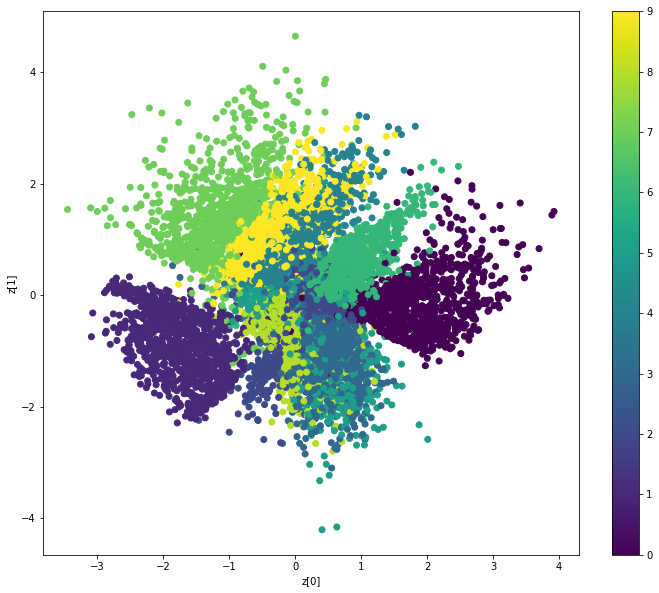

In [15]:
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")



We have now finished this step and I would like you to experiment with the number of latent variables and see if the loss function reduces. Also, experiment with the loss function. Don't forget to share your comments on the comments board.

If you want to generate new images go to the GitHub page I mentioned earlier. The code is there and you will be able to generate brand new images.

